In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\saima\OneDrive\Desktop\Projects\TrashType_Image_Dataset",      
    label_mode='categorical', # For multi-class classification
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\saima\OneDrive\Desktop\Projects\TrashType_Image_Dataset",      
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
])


In [6]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Freeze for transfer learning


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)   │ (None, 224, 224, 3)   │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ sequential (Sequential)      │ (None, 224, 224, 3)   │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ efficientnetv2-b0            │ (None, 7, 7, 1280)    │    5,919,312 │
│ (Functional)                 │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d     │ (None, 1280)          │            0 │
│ (GlobalAveragePooling2D)     │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)            │ (None, 1280)          │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                │ (None, 6)             │        7,686 │
└──────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]


In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8414 - loss: 0.5273

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.8411 - loss: 0.5278 - val_accuracy: 0.8317 - val_loss: 0.5092 - learning_rate: 1.0000e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8208 - loss: 0.5528

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - accuracy: 0.8208 - loss: 0.5526 - val_accuracy: 0.8396 - val_loss: 0.5000 - learning_rate: 1.0000e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8405 - loss: 0.5194

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.8403 - loss: 0.5197 - val_accuracy: 0.8416 - val_loss: 0.4909 - learning_rate: 1.0000e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8255 - loss: 0.5334

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 606ms/step - accuracy: 0.8255 - loss: 0.5334 - val_accuracy: 0.8455 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8345 - loss: 0.5166

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 622ms/step - accuracy: 0.8345 - loss: 0.5165 - val_accuracy: 0.8436 - val_loss: 0.4756 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8211 - loss: 0.5323

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 621ms/step - accuracy: 0.8213 - loss: 0.5320 - val_accuracy: 0.8475 - val_loss: 0.4695 - learning_rate: 1.0000e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8501 - loss: 0.4929

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.8500 - loss: 0.4930 - val_accuracy: 0.8515 - val_loss: 0.4634 - learning_rate: 1.0000e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.8484 - loss: 0.4903

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.8483 - loss: 0.4903 - val_accuracy: 0.8554 - val_loss: 0.4564 - learning_rate: 1.0000e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 82s/step - accuracy: 0.8431 - loss: 0.5052  

64/64 ━━━━━━━━━━━━━━━━━━━━ 5185s 82s/step - accuracy: 0.8431 - loss: 0.5052 - val_accuracy: 0.8535 - val_loss: 0.4503 - learning_rate: 1.0000e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.8217 - loss: 0.5124

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 664ms/step - accuracy: 0.8219 - loss: 0.5120 - val_accuracy: 0.8634 - val_loss: 0.4442 - learning_rate: 1.0000e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8574 - loss: 0.4677

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - accuracy: 0.8572 - loss: 0.4679 - val_accuracy: 0.8614 - val_loss: 0.4390 - learning_rate: 1.0000e-04
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8493 - loss: 0.4735

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 654ms/step - accuracy: 0.8493 - loss: 0.4734 - val_accuracy: 0.8634 - val_loss: 0.4338 - learning_rate: 1.0000e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8399 - loss: 0.4741

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 641ms/step - accuracy: 0.8400 - loss: 0.4741 - val_accuracy: 0.8673 - val_loss: 0.4294 - learning_rate: 1.0000e-04
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8383 - loss: 0.4792

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 641ms/step - accuracy: 0.8385 - loss: 0.4790 - val_accuracy: 0.8713 - val_loss: 0.4257 - learning_rate: 1.0000e-04
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8496 - loss: 0.4615

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 656ms/step - accuracy: 0.8496 - loss: 0.4615 - val_accuracy: 0.8713 - val_loss: 0.4212 - learning_rate: 1.0000e-04
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8565 - loss: 0.4654

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.8565 - loss: 0.4652 - val_accuracy: 0.8713 - val_loss: 0.4173 - learning_rate: 1.0000e-04
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8661 - loss: 0.4485

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.8661 - loss: 0.4483 - val_accuracy: 0.8693 - val_loss: 0.4135 - learning_rate: 1.0000e-04
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8594 - loss: 0.4437

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.8594 - loss: 0.4437 - val_accuracy: 0.8733 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 19/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8491 - loss: 0.4535

64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.8492 - loss: 0.4533 - val_accuracy: 0.8693 - val_loss: 0.4059 - learning_rate: 1.0000e-04
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8608 - loss: 0.4271

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.8608 - loss: 0.4270 - val_accuracy: 0.8713 - val_loss: 0.4023 - learning_rate: 1.0000e-04


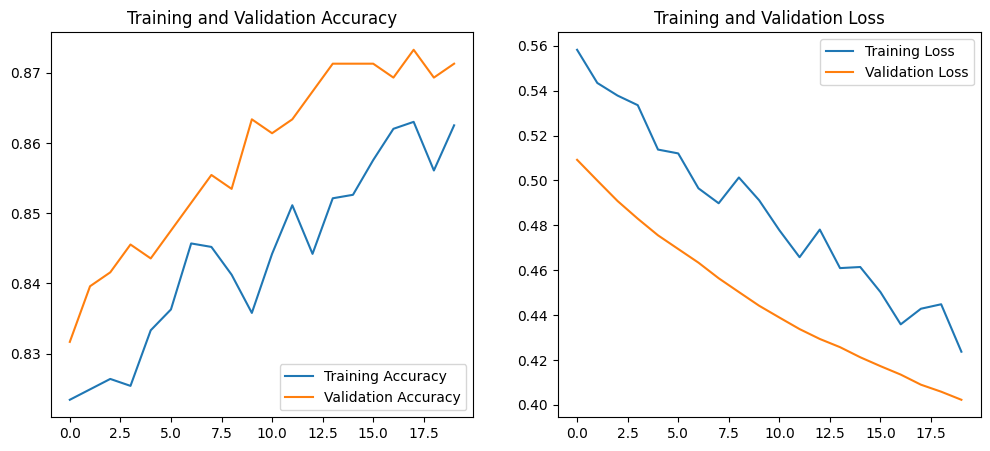

In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)


In [14]:
base_model.trainable = True

# Freeze bottom layers — unfreeze top few only (say, last 20 layers)
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 706ms/step - accuracy: 0.8396 - loss: 0.5500 - val_accuracy: 0.8396 - val_loss: 0.4815 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 646ms/step - accuracy: 0.8385 - loss: 0.5218 - val_accuracy: 0.8455 - val_loss: 0.4695 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 650ms/step - accuracy: 0.8466 - loss: 0.5119 - val_accuracy: 0.8475 - val_loss: 0.4596 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - accuracy: 0.8463 - loss: 0.5013 - val_accuracy: 0.8495 - val_loss: 0.4555 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.8437 - loss: 0.5135 - val_accuracy: 0.8495 - val_loss: 0.4480 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.8564 - loss: 0.4726 - val_accuracy: 0.8554 - val_loss: 0.4420 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 633ms/step - acc

In [15]:
# Evaluate on val set
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.8823 - loss: 0.4129
Validation Accuracy: 87.13%
